## **Market Basket Analysis using the Online Retail Dataset**

### **Introduction**

In this notebook, we will perform a Market Basket Analysis on the **Online Retail** dataset. Market Basket Analysis is a data mining technique that identifies patterns of co-occurrence among items within transactions. It is widely used in retail to discover associations between products, helping businesses understand customer purchasing behavior and optimize their inventory and marketing strategies.

### **Objectives**

1. **Data Exploration and Preprocessing:**
   - Load and explore the dataset to understand its structure and contents.
   - Clean the data by handling missing values, removing canceled orders, and filtering out irrelevant entries.

2. **Data Preparation for Association Rules Mining:**
   - Transform the data into a suitable format for Market Basket Analysis.
   - Create a transaction matrix where each row represents a transaction and each column represents a product.

3. **Market Basket Analysis:**
   - Apply the **Apriori** algorithm to identify frequent itemsets in the transactions.
   - Generate **association rules** from the frequent itemsets to discover relationships between products.

4. **Results Interpretation:**
   - Analyze the results to gain insights into customer buying patterns.
   - Identify strong association rules that can be leveraged for cross-selling, up-selling, or marketing strategies.

### **Tools and Techniques**

- **Pandas** for data manipulation and cleaning.
- **Apriori Algorithm** from the `mlxtend` library for mining frequent itemsets.
- **Association Rules Mining** to uncover meaningful relationships between products.
- **Visualization** tools such as Matplotlib and Seaborn for presenting the findings.

### **Outcome**

By the end of this notebook, we will have identified key product associations that can inform business decisions, such as product placement, promotion, and inventory management.

### Importing Libraries 
Start by importing the necessary libraries for data manipulation, visualization, and analysis.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

import warnings
warnings.filterwarnings("ignore") 

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

###  Loading Data
Load the Online Retail dataset into a Pandas DataFrame.

In [2]:
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Basic Information about the Dataset

In [3]:
# Shape 
df.shape

(541909, 8)

In [4]:
# Column name, Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Statistical Overview
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Data Cleaning
Clean the data by handling missing values, removing canceled orders, and filtering out irrelevant entries.

In [6]:
# Check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Stripping Whitespace
df['Description'] = df['Description'].str.strip()
df['Country'] = df['Country'].str.strip()

In [8]:
# Dropping Rows with Missing InvoiceNo
df.dropna(axis = 0, subset=['InvoiceNo'], inplace = True)

# Converting InvoiceNo to String
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

# Removing Canceled Transactions
df = df[~df['InvoiceNo'].str.contains('C')]

# Remove canceled transactions (those with negative quantities)
df = df[df['Quantity'] > 0]

In [9]:
# Check for Duplicates values
df.duplicated().sum()

5231

In [10]:
# Remove duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)

In [11]:
# Data distribution by country
df.groupby('Country').count().reset_index().sort_values('InvoiceNo', ascending = False).head()

,Country,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
36,United Kingdom,481143,481143,480551,481143,481143,481143,349227
14,Germany,9027,9027,9027,9027,9027,9027,9027
13,France,8393,8393,8393,8393,8393,8393,8327
10,EIRE,7883,7883,7883,7883,7883,7883,7228
31,Spain,2480,2480,2480,2480,2480,2480,2480


### Data Preparation
Prepare the data by creating a basket matrix where each row represents a transaction and each column represents a product.

Your data preparation for Germany is done well. Here’s an assessment of each step:

1. **Filtering and creating the basket matrix**          
2. **Converting quantities into binary values**
3. **Dropping 'POSTAGE'**

Thus, we see that most of the transactions occur in the UK, and there are more frequent customers in UK.

For the sake of this analysis, we will look at the transactions in Germany, and later with UK or France or EIRE to see if there is a difference in product purchase behaviour accross countries.

### 1-hot encoding : 
* This is the process pf consolidating items into one transaction per row.
* This can be done manually like below, or via the mlxtend.
* The one-hot encoding from mxltend encodes transaction data in form of a Python list into a NumPy integer array.
* The colums represent unique items present in the input array, and rows represent the individual transactions.
* Before proceeding with the 1-hot encoding, let us see the number of transactions by country.

In [12]:
# Create a basket matrix for a specific country, e.g., 'Germany'
Basket = (df[df['Country']=="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

Basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Function to convert quantities into binary values
def sum_to_boolean(x):
    if x<=0:
        return 0
    else:
        return 1

Basket_Final = Basket.applymap(sum_to_boolean)

In [14]:
# Drop the 'POSTAGE' column if it exists
if 'POSTAGE' in Basket_Final.columns:
    Basket_Final.drop('POSTAGE', inplace=True, axis=1)

# Display the first few rows of the cleaned basket matrix
Basket_Final.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Applying the Apriori Algorithm
Use the Apriori algorithm to identify frequent itemsets (that have a support of atleast 6%) and then generate association rules. 

In [15]:
# Find frequent itemsets
frequent_itemsets = apriori(Basket_Final, min_support=0.06, use_colnames=True)

# Display the frequent itemsets
frequent_itemsets.sort_values('support', ascending = False).head()

C:\Users\Datacore\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
27,0.245077,(ROUND SNACK BOXES SET OF4 WOODLAND)
26,0.157549,(ROUND SNACK BOXES SET OF 4 FRUITS)
19,0.137856,(PLASTERS IN TIN WOODLAND ANIMALS)
24,0.137856,(REGENCY CAKESTAND 3 TIER)
36,0.131291,"(ROUND SNACK BOXES SET OF 4 FRUITS, ROUND SNAC..."


### Generating Association Rules
Generate association rules from the frequent itemsets to find relationships between products.

In [16]:
# Generate association rules with lift as the metric and a minimum threshold of 1
Asso_Rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)

# Sort the rules by lift in descending order
Asso_Rules.sort_values('lift',ascending = False)

# Display the sorted association rules
#Asso_Rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.137856,0.115974,0.067834,0.492063,4.242887,0.051846,1.740427,0.886524
1,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984,0.864580
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.137856,0.107221,0.061269,0.444444,4.145125,0.046488,1.607002,0.880076
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670,0.849877
6,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540,0.837922
7,(ROUND SNACK BOXES SET OF4 WOODLAND),(ROUND SNACK BOXES SET OF 4 FRUITS),0.245077,0.157549,0.131291,0.535714,3.400298,0.092679,1.814509,0.935072
9,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427,0.713415
8,(ROUND SNACK BOXES SET OF4 WOODLAND),(SPACEBOY LUNCH BOX),0.245077,0.102845,0.070022,0.285714,2.778116,0.044817,1.256018,0.847826
5,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951,0.723103
4,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006,0.633174


### Interpreting the Results
Finally, analyze the association rules to identify strong relationships between products that can be leveraged for business strategies.

In [17]:
# Focus on strong rules (e.g., with lift > 3)
strong_rules = Asso_Rules[Asso_Rules['lift'] > 3]

# Display strong rules
strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.067834,0.492063,4.242887
1,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.067834,0.584906,4.242887
2,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.061269,0.444444,4.145125
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.061269,0.571429,4.145125
6,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.131291,0.833333,3.400298
7,(ROUND SNACK BOXES SET OF4 WOODLAND),(ROUND SNACK BOXES SET OF 4 FRUITS),0.131291,0.535714,3.400298


**Observation**   
This result appears to be from an association rule mining analysis, likely using the Apriori algorithm or a similar technique. It shows how frequently items are purchased together (support), how likely one item is purchased given the presence of another (confidence), and how much more likely the items are purchased together than would be expected if they were independent (lift). Here's how to interpret each column:

1. **Antecedents**: The item(s) or product(s) that are present in the transaction.
2. **Consequents**: The item(s) or product(s) that are likely to be purchased given the antecedents.
3. **Support**: The proportion of transactions that include both the antecedents and consequents. It shows how frequently the rule is applicable.
4. **Confidence**: The probability that the consequent is purchased given that the antecedent is purchased. It measures the reliability of the rule.
5. **Lift**: The ratio of the observed support to the expected support if the antecedents and consequents were independent. It indicates how much more likely the consequent is to be purchased when the antecedent is purchased, compared to if they were independent.

### Interpretation of the Results

1. **Rule 1**: 
   - **Antecedent**: "PLASTERS IN TIN CIRCUS PARADE"
   - **Consequent**: "PLASTERS IN TIN WOODLAND ANIMALS"
   - **Support**: 0.0678 (6.78% of transactions include both items)
   - **Confidence**: 0.5849 (58.49% of the time, "PLASTERS IN TIN CIRCUS PARADE" is bought, "PLASTERS IN TIN WOODLAND ANIMALS" is also bought)
   - **Lift**: 4.2429 (The presence of "PLASTERS IN TIN CIRCUS PARADE" increases the likelihood of buying "PLASTERS IN TIN WOODLAND ANIMALS" by about 4.24 times compared to random chance)

2. **Rule 2**:
   - **Antecedent**: "PLASTERS IN TIN WOODLAND ANIMALS"
   - **Consequent**: "PLASTERS IN TIN CIRCUS PARADE"
   - **Support**: 0.0678
   - **Confidence**: 0.4921
   - **Lift**: 4.2429 (Similar interpretation as Rule 1, but in reverse direction)

3. **Rule 3**:
   - **Antecedent**: "PLASTERS IN TIN SPACEBOY"
   - **Consequent**: "PLASTERS IN TIN WOODLAND ANIMALS"
   - **Support**: 0.0613
   - **Confidence**: 0.5714
   - **Lift**: 4.1451 (The likelihood of buying "PLASTERS IN TIN WOODLAND ANIMALS" increases by 4.15 times when "PLASTERS IN TIN SPACEBOY" is bought)

### Summary

- **High Confidence and Lift**: Rules with high confidence and lift values indicate strong associations between items. For example, the rules with "PLASTERS IN TIN CIRCUS PARADE" and "PLASTERS IN TIN WOODLAND ANIMALS" have high lift values, meaning there's a strong relationship between these items being purchased together.
- **Support**: Higher support means the rule is applicable to a larger proportion of transactions, which could be useful for understanding the prevalence of the association.

These results can help in product placement strategies, cross-selling opportunities, and promotional planning.

In [18]:
Basket['PLASTERS IN TIN WOODLAND ANIMALS'].sum()

856.0

In [19]:
Basket['PLASTERS IN TIN CIRCUS PARADE'].sum()

774.0

### Conclussion: 
From the Germany Sales dataset, the most popular (frequently purhcased) item is Plasters in tin woodland animals, followed by plasters in tin circus parade.

Since both these products are purchased very frequently (as recommended by the association rules), the popularity of the tin woodland animals can be used to drive sales of tin circus parade through cobo offers or something.

## Purchase behaviour in UK

In [20]:
# Creating Basket 
Basket_UK = (df[df['Country']=='United Kingdom']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# convert quantities into binary values
def sum_to_boolean(x):
    if x<=0:
        return 0
    else:
        return 1

# Drop irrelevant columns if needed
if 'POSTAGE' in Basket_UK.columns:
    Basket_UK.drop('POSTAGE', inplace=True, axis=1)

In [21]:
# convert quantities into binary values
Basket_Final_UK = Basket_UK.applymap(sum_to_boolean)
Frequent_itemsets_UK = apriori(Basket_Final_UK, min_support = 0.03, use_colnames = True)

# Aplying Associate Rules
Asso_Rules_UK = association_rules(Frequent_itemsets_UK, metric = "lift", min_threshold = 0.5)
Asso_Rules_UK.sort_values('lift',ascending = False).head()

C:\Users\Datacore\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.051336,0.038639,0.031714,0.617773,15.988282,0.029730,2.515157,0.988183
3,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038639,0.051336,0.031714,0.820768,15.988282,0.029730,5.292945,0.975132
19,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.052600,0.038639,0.030010,0.570533,14.765684,0.027977,2.238497,0.984035
18,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038639,0.052600,0.030010,0.776671,14.765684,0.027977,4.242181,0.969746
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.051336,0.052600,0.038529,0.750535,14.268798,0.035829,3.797733,0.980238


In [22]:
num_rules = Asso_Rules_UK.shape[0]
print(f'Total Association Rules: {num_rules}')

Total Association Rules: 20


In [23]:
# Focus on strong rules (e.g., with lift > 3)
strong_rules = Asso_Rules_UK[Asso_Rules_UK['lift'] > 3]

# Display strong rules
strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.030944,0.642694,12.573307
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.030944,0.605376,12.573307
2,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031714,0.617773,15.988282
3,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031714,0.820768,15.988282
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038529,0.750535,14.268798
5,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038529,0.732497,14.268798
6,(JUMBO BAG RED RETROSPOT),(JUMBO BAG BAROQUE BLACK WHITE),0.031329,0.294118,5.880414
7,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.031329,0.626374,5.880414
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.043146,0.677308,6.358587
9,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.043146,0.405057,6.358587


In [24]:
Basket_UK['ALARM CLOCK BAKELIKE GREEN'].sum()

5620.0

In [25]:
Basket_UK['ALARM CLOCK BAKELIKE RED'].sum()

6641.0

**Observation**   
The analysis identifies several strong association rules with high lift values, indicating significant relationships between products. Key observations include:

1. **High Lift Values**: The rules involving `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED` show a lift of 12.57, suggesting that these two items are purchased together much more often than expected by chance. Similarly, `GREEN REGENCY TEACUP AND SAUCER` and `PINK REGENCY TEACUP AND SAUCER` have a lift of 15.99, and `GREEN REGENCY TEACUP AND SAUCER` and `ROSES REGENCY TEACUP AND SAUCER` have a lift of 14.27, indicating a strong association.

2. **Symmetrical Relationships**: Many of the strong rules are symmetrical, meaning the association works in both directions. For instance, `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED` have high lift values in both directions.

3. **Diverse Products**: The analysis also reveals strong associations between other product pairs, such as various types of `JUMBO BAG` and `LUNCH BAG` items, with lift values ranging from 5.44 to 7.20, showing notable purchasing patterns.

Overall, these strong association rules can help in understanding which products are frequently bought together, allowing for better cross-selling strategies and promotional planning.

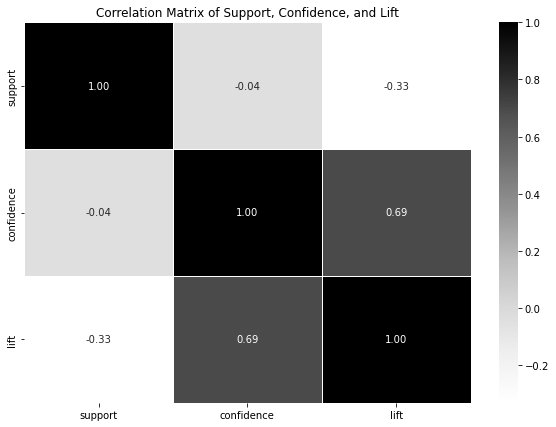

In [26]:
# Calculate the correlation matrix
correlation_matrix = Asso_Rules_UK[['support', 'confidence', 'lift']].corr()

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='Greys', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Support, Confidence, and Lift')
plt.show()

**Observation**   
* Support and confidence are almost uncorrelated.
* Support and lift have a moderate negative correlation, implying that very frequent itemsets might not have the highest lift values.
* Confidence and lift are strongly positively correlated, suggesting that rules with higher confidence are likely to have higher lift values, indicating stronger relationships between items.

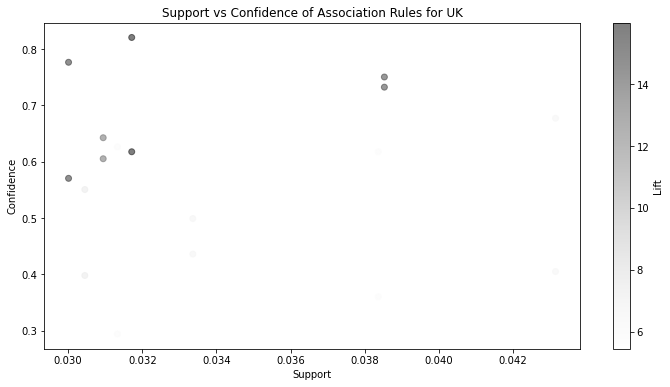

In [27]:
# The relationship between support and confidence of the association rules for the UK

plt.figure(figsize=(12, 6))
plt.scatter(Asso_Rules_UK['support'], Asso_Rules_UK['confidence'], alpha=0.5, c=Asso_Rules_UK['lift'], cmap='Greys')
plt.title('Support vs Confidence of Association Rules for UK')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar(label='Lift')
plt.show()

### Conclusion

Based on the association rule mining conducted on the UK dataset using the Apriori algorithm, several key findings and insights have emerged:

1. **Strong Associations**: The analysis identified several strong association rules with high lift values, indicating significant relationships between products. For instance, pairs like `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED` or `GREEN REGENCY TEACUP AND SAUCER` and `PINK REGENCY TEACUP AND SAUCER` have high lift values, suggesting that these items are frequently purchased together and have a strong dependency.

2. **Correlation Insights**: The correlation matrix revealed:
   - **Weak Correlation between Support and Confidence**: Support and confidence are nearly uncorrelated, indicating that the frequency of an itemset does not necessarily predict the likelihood of a consequent being purchased.
   - **Moderate Negative Correlation between Support and Lift**: As support increases, lift tends to decrease, suggesting that highly frequent itemsets do not always exhibit strong associations.
   - **Strong Positive Correlation between Confidence and Lift**: Higher confidence values are associated with higher lift values, indicating that rules with higher confidence tend to have stronger relationships between antecedents and consequents.

### Recommendations

1. **Focus on High Lift Rules**: Given that high lift values indicate strong associations, prioritize marketing and promotional strategies around items with high lift values. For example, consider bundling `ALARM CLOCK BAKELIKE GREEN` and `ALARM CLOCK BAKELIKE RED` together or promoting `GREEN REGENCY TEACUP AND SAUCER` alongside `PINK REGENCY TEACUP AND SAUCER` to maximize cross-sell opportunities (**Product Placement**)

2. **Evaluate Itemsets with Moderate Support**: Since very frequent itemsets often show lower lift, explore itemsets with moderate support that may still exhibit strong associations. This could help identify less obvious, yet profitable, combinations of products.

3. **Optimize Inventory and Promotions**: Use insights from strong association rules to optimize inventory management and design targeted promotions. For example, if certain items are frequently bought together, ensure they are prominently displayed together in stores or offer discounts when purchasing them as a bundle.

4. **Monitor and Adjust**: Continuously monitor the performance of association-based promotions and adjust strategies based on updated data. This ensures that marketing efforts remain aligned with current consumer purchasing patterns.

5. **Enhance Customer Experience**: Leverage the findings to enhance the shopping experience. For instance, personalized recommendations based on the strong associations can improve customer satisfaction and increase sales.

By applying these recommendations, businesses can effectively leverage the insights from association rule mining to boost sales, enhance customer experience, and optimize marketing strategies.

### Data Visualization
Explore the data and visualize some key insights.

In [28]:
df_UK= df[df['Country']=='United Kingdom']

### Basic Statistics

In [29]:
# Unique Products
unique_products = df_UK['Description'].nunique()
# Unique Customers
unique_customers = df_UK['CustomerID'].nunique()
# Total Transactions
total_transactions = df_UK['InvoiceNo'].nunique()
# Total Quantity Sold
total_quantity_sold = df_UK['Quantity'].sum()
# Total Revenue
total_revenue = (df_UK['Quantity'] * df_UK['UnitPrice']).sum()
# Average Order Value (AOV)
aov = total_revenue/total_transactions 
# Average number of products per purchase 
average_products_per_purchase= df_UK.groupby('InvoiceNo')['StockCode'].count().mean()

# Print the results
print(f"Unique Products: {unique_products}")
print(f"Unique Customers: {unique_customers}")
print(f"Total Transactions: {total_transactions}")
print(f"Total Quantity Sold: {total_quantity_sold}")
print(f"Total Revenue: £{total_revenue:.2f}")
print(f'Average Order Value: £{aov:.2f}')
print(f"Average Number Of Products per Purchase :{average_products_per_purchase}")

Unique Products: 4046
Unique Customers: 3921
Total Transactions: 18786
Total Quantity Sold: 4718329
Total Revenue: £8979619.97
Average Order Value: £478.00
Average Number Of Products per Purchase :25.611785372085595


### Top 10 Products by Purchased Frequency and Revenue

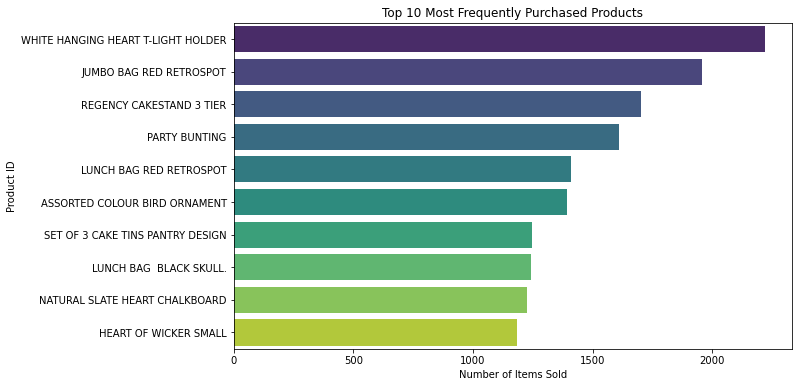

In [35]:
# Top 10 most frequently purchased products
top_products = df_UK['Description'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_products.index, x=top_products.values, palette='viridis')
plt.title('Top 10 Most Frequently Purchased Products')
#plt.xticks(rotation=90)
plt.ylabel('Product ID')
plt.xlabel('Number of Items Sold')
plt.show()

In [36]:
top_products

WHITE HANGING HEART T-LIGHT HOLDER    2220
JUMBO BAG RED RETROSPOT               1957
REGENCY CAKESTAND 3 TIER              1702
PARTY BUNTING                         1608
LUNCH BAG RED RETROSPOT               1409
ASSORTED COLOUR BIRD ORNAMENT         1392
SET OF 3 CAKE TINS PANTRY DESIGN      1248
LUNCH BAG  BLACK SKULL.               1244
NATURAL SLATE HEART CHALKBOARD        1225
HEART OF WICKER SMALL                 1182
Name: Description, dtype: int64

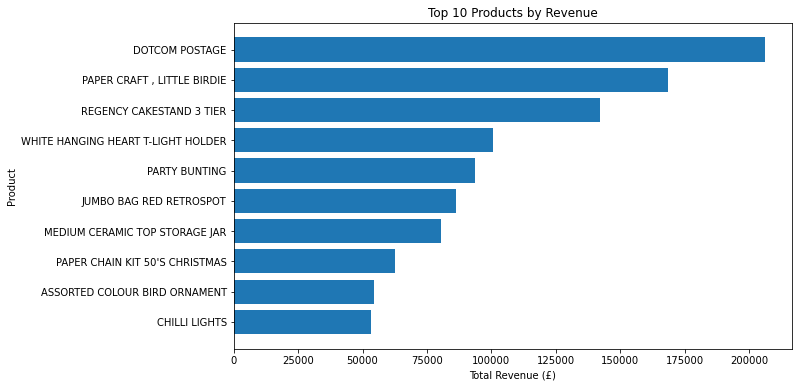

In [37]:
# Top Products by Revenue
top_products = df_UK.groupby('Description').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum()).reset_index()
top_products.columns = ['Description', 'TotalRevenue']
top_products = top_products.sort_values(by='TotalRevenue', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_products['Description'], top_products['TotalRevenue'])
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Product')
plt.gca().invert_yaxis()
plt.show()

In [38]:
top_products

,Description,TotalRevenue
1057,DOTCOM POSTAGE,206248.77
2381,"PAPER CRAFT , LITTLE BIRDIE",168469.60
2841,REGENCY CAKESTAND 3 TIER,141996.09
3831,WHITE HANGING HEART T-LIGHT HOLDER,100444.62
2406,PARTY BUNTING,93599.43
1808,JUMBO BAG RED RETROSPOT,86291.10
2044,MEDIUM CERAMIC TOP STORAGE JAR,80575.63
2375,PAPER CHAIN KIT 50'S CHRISTMAS,62683.54
218,ASSORTED COLOUR BIRD ORNAMENT,54589.48
740,CHILLI LIGHTS,53315.16


### Sales Trend Over Time

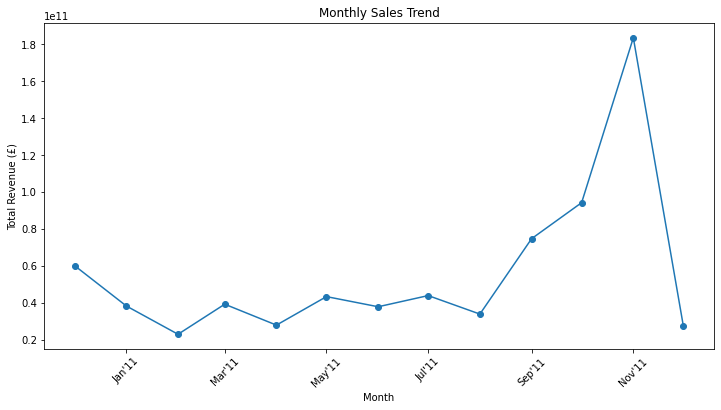

In [32]:
import matplotlib.dates as mdates

# Aggregate data by month
monthly_sales = df_UK.groupby(df_UK['InvoiceDate'].dt.to_period('M')).agg({'Quantity': 'sum', 'UnitPrice': 'sum'})
monthly_sales['TotalRevenue'] = monthly_sales['Quantity'] * monthly_sales['UnitPrice']
monthly_sales.reset_index(inplace=True)
# Convert period to datetime for plotting
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['TotalRevenue'], marker='o')

# Format x-axis labels as 'Dec'21'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\'%y'))

plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.show()

In [39]:
monthly_sales

,InvoiceDate,Quantity,UnitPrice,TotalRevenue
0,2010-12-01,316027,190471.500,6.019414e+10
1,2011-01-01,325046,118049.670,3.837157e+10
2,2011-02-01,232824,99018.130,2.305380e+10
3,2011-03-01,311491,126275.450,3.933367e+10
4,2011-04-01,278777,100484.811,2.801285e+10
5,2011-05-01,324667,133815.310,4.344542e+10
6,2011-06-01,309553,122612.150,3.795496e+10
7,2011-07-01,338103,130151.061,4.400446e+10
8,2011-08-01,334456,101620.490,3.398758e+10
9,2011-09-01,482496,155049.542,7.481078e+10


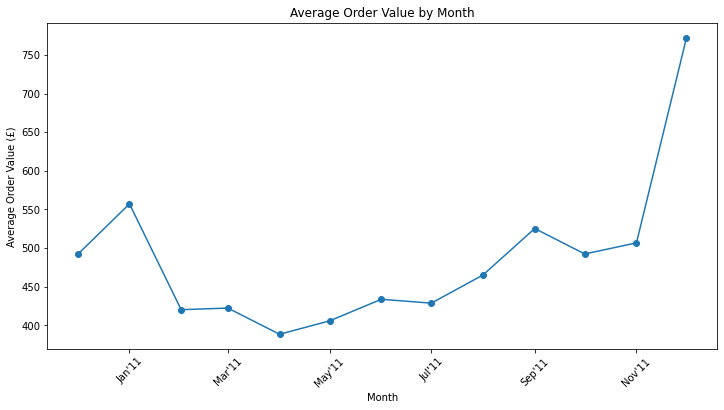

In [33]:
# Calculate total revenue per order
df_UK['TotalRevenue'] = df_UK['Quantity'] * df_UK['UnitPrice']

# Aggregate data by month and order
monthly_order_value = df_UK.groupby([df_UK['InvoiceDate'].dt.to_period('M'), 'InvoiceNo'])['TotalRevenue'].sum().reset_index()

# Calculate average order value per month
monthly_avg_order_value = monthly_order_value.groupby('InvoiceDate')['TotalRevenue'].mean().reset_index()

# Convert period to timestamp for plotting
monthly_avg_order_value['InvoiceDate'] = monthly_avg_order_value['InvoiceDate'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_order_value['InvoiceDate'], monthly_avg_order_value['TotalRevenue'], marker='o')

# Format x-axis labels as 'Dec'21'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\'%y'))

plt.title('Average Order Value by Month')
plt.xlabel('Month')
plt.ylabel('Average Order Value (£)')
plt.xticks(rotation=45)
plt.grid(False)  # Remove gridlines
plt.show()

In [34]:
monthly_avg_order_value

,InvoiceDate,TotalRevenue
0,2010-12-01,491.814252
1,2011-01-01,557.189881
2,2011-02-01,420.163193
3,2011-03-01,422.246051
4,2011-04-01,388.308270
5,2011-05-01,405.661087
6,2011-06-01,433.622391
7,2011-07-01,428.615600
8,2011-08-01,465.123954
9,2011-09-01,525.292630


In [40]:
# Dataset with the columns Quantity, UnitPrice, TotalRevenue, Average Order Value, and Total Customers

# Calculate Total Revenue per transaction
df_UK['TotalRevenue'] = df_UK['Quantity'] * df_UK['UnitPrice']

# Aggregate data by month and order
monthly_data = df_UK.groupby([df_UK['InvoiceDate'].dt.to_period('M')]).agg(
    Quantity=('Quantity', 'sum'),
    TotalRevenue=('TotalRevenue', 'sum'),
    TotalOrders=('InvoiceNo', 'nunique'),
    TotalCustomers=('CustomerID', 'nunique')
).reset_index()

# Calculate Average Order Value
monthly_data['AverageOrderValue'] = monthly_data['TotalRevenue'] / monthly_data['TotalOrders']

# Convert period to timestamp for easier plotting
monthly_data['InvoiceDate'] = monthly_data['InvoiceDate'].dt.to_timestamp()

# Rearrange columns
monthly_data = monthly_data[['InvoiceDate', 'Quantity', 'TotalRevenue', 'AverageOrderValue', 'TotalCustomers']]

monthly_data

,InvoiceDate,Quantity,TotalRevenue,AverageOrderValue,TotalCustomers
0,2010-12-01,316027,746082.220,491.814252,815
1,2011-01-01,325046,559975.830,557.189881,647
2,2011-02-01,232824,428986.620,420.163193,679
3,2011-03-01,311491,584810.780,422.246051,880
4,2011-04-01,278777,475677.631,388.308270,784
5,2011-05-01,324667,638104.890,405.661087,962
6,2011-06-01,309553,618345.530,433.622391,889
7,2011-07-01,338103,600919.071,428.615600,859
8,2011-08-01,334456,584660.810,465.123954,834
9,2011-09-01,482496,895098.642,525.292630,1146


### Customer Purchase Behavior

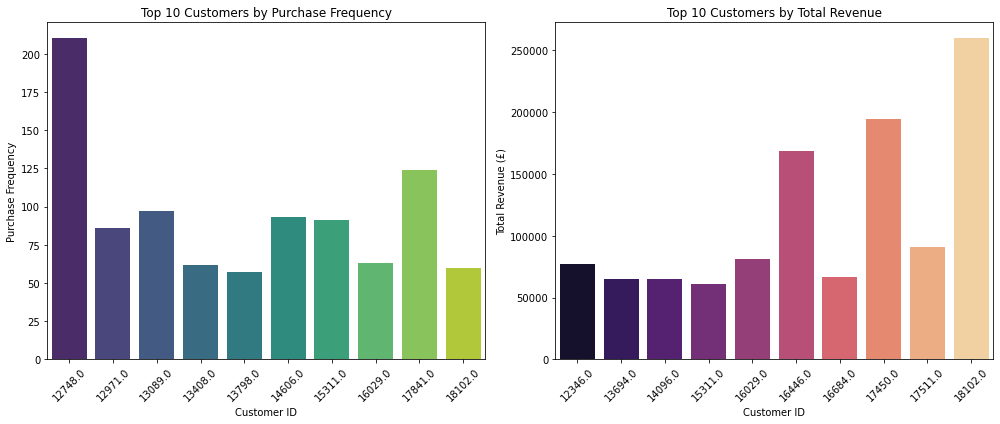

In [41]:
# 10 customers by purchase frequency and Revenue Generation
# Calculate purchase frequency and total revenue for each customer
customer_summary = df_UK.groupby('CustomerID').agg(
    PurchaseFrequency=('InvoiceNo', 'nunique'),
    TotalRevenue=('TotalRevenue', 'sum')
).reset_index()

# Sort and select top 10 customers by purchase frequency
top_10_frequency = customer_summary.sort_values(by='PurchaseFrequency', ascending=False).head(10)

# Sort and select top 10 customers by total revenue
top_10_revenue = customer_summary.sort_values(by='TotalRevenue', ascending=False).head(10)

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Bar plot for top 10 customers by purchase frequency
plt.subplot(1, 2, 1)
sns.barplot(data=top_10_frequency, x='CustomerID', y='PurchaseFrequency', palette='viridis')
plt.title('Top 10 Customers by Purchase Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Purchase Frequency')
plt.xticks(rotation=45)

# Bar plot for top 10 customers by total revenue
plt.subplot(1, 2, 2)
sns.barplot(data=top_10_revenue, x='CustomerID', y='TotalRevenue', palette='magma')
plt.title('Top 10 Customers by Total Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

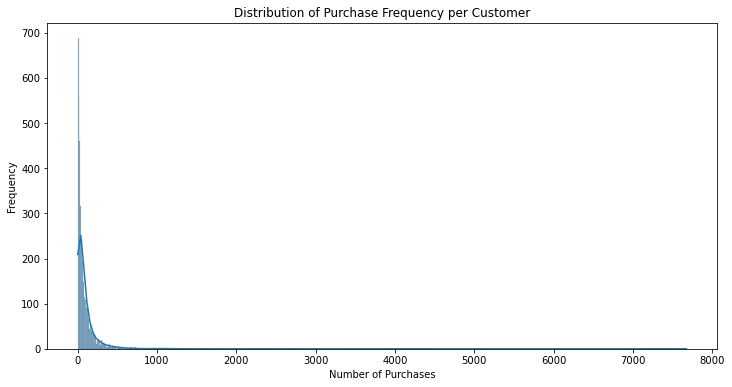

In [42]:
# Customer Purchase Frequency

# Aggregate data by customer
customer_purchase_frequency = df_UK.groupby('CustomerID').size().reset_index(name='PurchaseFrequency')

plt.figure(figsize=(12, 6))
sns.histplot(customer_purchase_frequency['PurchaseFrequency'], kde=True)
plt.title('Distribution of Purchase Frequency per Customer')
plt.xlabel('Number of Purchases')
plt.ylabel('Frequency')
plt.grid(False)  # Remove gridlines
plt.show()

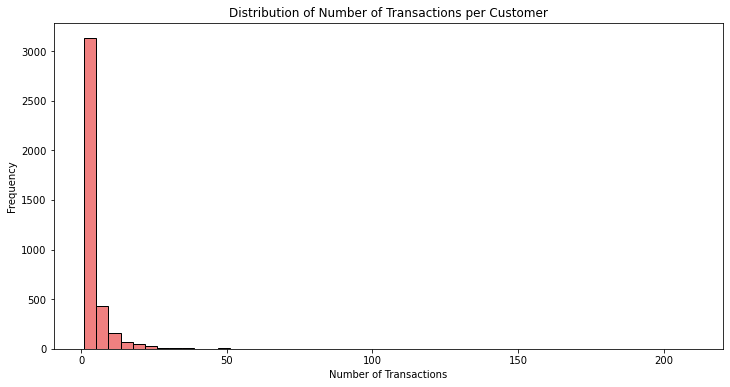

In [43]:
customer_transactions = df_UK.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(12, 6))
plt.hist(customer_transactions, bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

### Top 10 Products Co-occurrence

### Based on Frequently purchased history

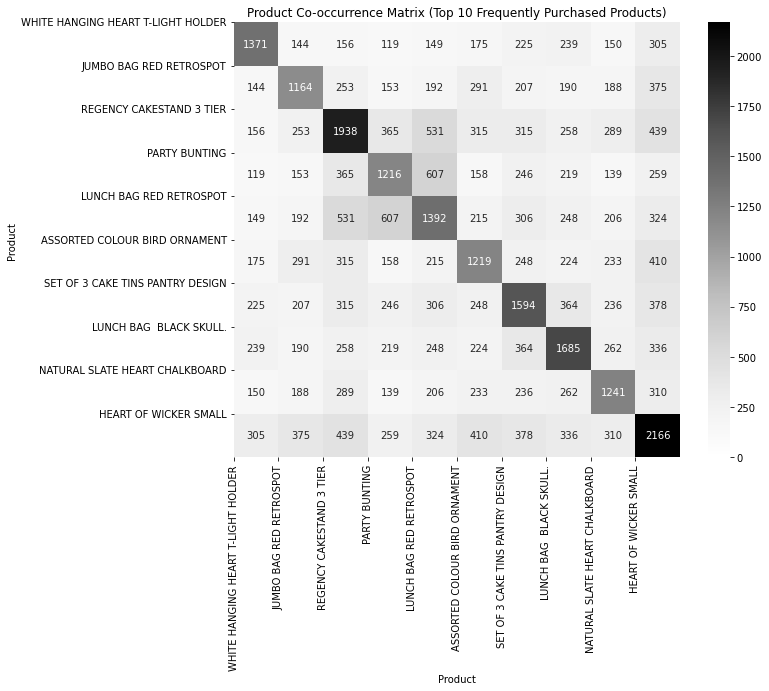

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify the top 10 products based on total quantity sold
top_products_freq = df_UK['Description'].value_counts().nlargest(10).index
#top_products_freq = df_UK.groupby('Description')['Quantity'].sum().nlargest(10).index

# Step 2: Create a basket matrix for these top 10 products
basket_freq = df_UK[df_UK['Description'].isin(top_products_freq)]
basket_freq = basket_freq.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket_freq = basket_freq.set_index('InvoiceNo')
basket_freq = basket_freq.applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Compute co-occurrence matrix for top 10 products
co_occurrence_freq = basket_freq.T.dot(basket_freq)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_freq, cmap='Greys', annot=True, fmt='d', vmin=0)
plt.title('Product Co-occurrence Matrix (Top 10 Frequently Purchased Products)')
plt.xlabel('Product')
plt.ylabel('Product')
plt.xticks(ticks=range(len(top_products_freq)), labels=top_products_freq, rotation=90)
plt.yticks(ticks=range(len(top_products_freq)), labels=top_products_freq, rotation=0)
plt.show()

In [47]:
co_occurrence_freq

Description,ASSORTED COLOUR BIRD ORNAMENT,HEART OF WICKER SMALL,JUMBO BAG RED RETROSPOT,LUNCH BAG BLACK SKULL.,LUNCH BAG RED RETROSPOT,NATURAL SLATE HEART CHALKBOARD,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,SET OF 3 CAKE TINS PANTRY DESIGN,WHITE HANGING HEART T-LIGHT HOLDER
Description,,,,,,,,,,
ASSORTED COLOUR BIRD ORNAMENT,1371,144,156,119,149,175,225,239,150,305
HEART OF WICKER SMALL,144,1164,253,153,192,291,207,190,188,375
JUMBO BAG RED RETROSPOT,156,253,1938,365,531,315,315,258,289,439
LUNCH BAG BLACK SKULL.,119,153,365,1216,607,158,246,219,139,259
LUNCH BAG RED RETROSPOT,149,192,531,607,1392,215,306,248,206,324
NATURAL SLATE HEART CHALKBOARD,175,291,315,158,215,1219,248,224,233,410
PARTY BUNTING,225,207,315,246,306,248,1594,364,236,378
REGENCY CAKESTAND 3 TIER,239,190,258,219,248,224,364,1685,262,336
SET OF 3 CAKE TINS PANTRY DESIGN,150,188,289,139,206,233,236,262,1241,310


### Based on Revenue

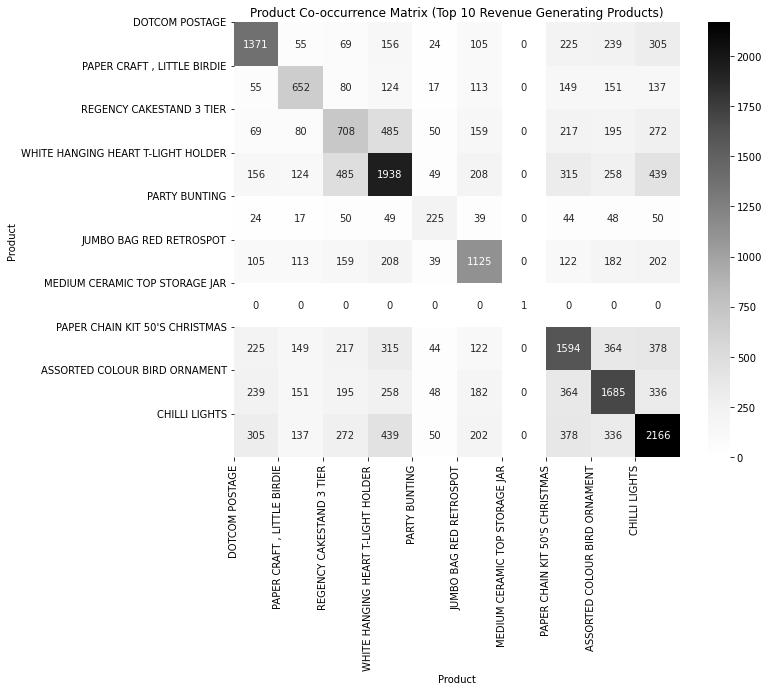

In [51]:
# Step 1: Identify the top 10 products based on total revenue
top_products_revenue = df_UK.groupby('Description')['TotalRevenue'].sum().nlargest(10).index

# Step 2: Create a basket matrix for these top 10 products
basket_revenue = df_UK[df_UK['Description'].isin(top_products_revenue)]
basket_revenue = basket_revenue.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket_revenue = basket_revenue.set_index('InvoiceNo')
basket_revenue = basket_revenue.applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Compute co-occurrence matrix for top 10 products
co_occurrence_revenue = basket_revenue.T.dot(basket_revenue)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_revenue, cmap='Greys', annot=True, fmt='d', vmin=0)
plt.title('Product Co-occurrence Matrix (Top 10 Revenue Generating Products)')
plt.xlabel('Product')
plt.ylabel('Product')
plt.xticks(ticks=range(len(top_products_revenue)), labels=top_products_revenue, rotation=90)
plt.yticks(ticks=range(len(top_products_revenue)), labels=top_products_revenue, rotation=0)
plt.show()

In [49]:
co_occurrence_revenue

Description,ASSORTED COLOUR BIRD ORNAMENT,CHILLI LIGHTS,DOTCOM POSTAGE,JUMBO BAG RED RETROSPOT,MEDIUM CERAMIC TOP STORAGE JAR,PAPER CHAIN KIT 50'S CHRISTMAS,"PAPER CRAFT , LITTLE BIRDIE",PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
Description,,,,,,,,,,
ASSORTED COLOUR BIRD ORNAMENT,1371,55,69,156,24,105,0,225,239,305
CHILLI LIGHTS,55,652,80,124,17,113,0,149,151,137
DOTCOM POSTAGE,69,80,708,485,50,159,0,217,195,272
JUMBO BAG RED RETROSPOT,156,124,485,1938,49,208,0,315,258,439
MEDIUM CERAMIC TOP STORAGE JAR,24,17,50,49,225,39,0,44,48,50
PAPER CHAIN KIT 50'S CHRISTMAS,105,113,159,208,39,1125,0,122,182,202
"PAPER CRAFT , LITTLE BIRDIE",0,0,0,0,0,0,1,0,0,0
PARTY BUNTING,225,149,217,315,44,122,0,1594,364,378
REGENCY CAKESTAND 3 TIER,239,151,195,258,48,182,0,364,1685,336


### Based on Quantity

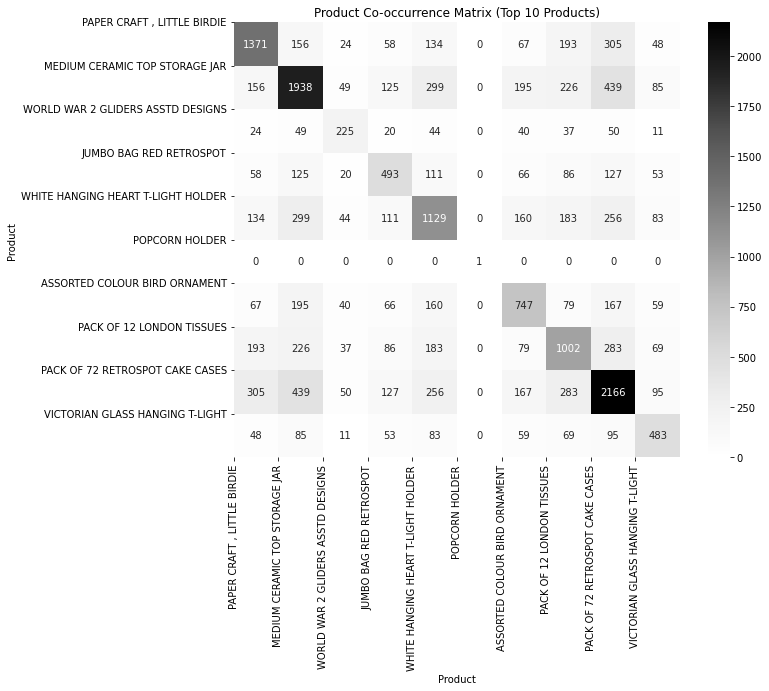

In [53]:
# top 10 products in the co-occurrence matrix

# Step 1: Identify the top 10 products based on total quantity sold
top_products = df_UK.groupby('Description')['Quantity'].sum().nlargest(10).index

# Step 2: Create a basket matrix for these top 10 products
basket = df_UK[df_UK['Description'].isin(top_products)]
basket = basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket = basket.set_index('InvoiceNo')
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Step 3: Compute co-occurrence matrix for top 10 products
co_occurrence = basket.T.dot(basket)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence, cmap='Greys', annot=True, fmt='d', vmin=0)
plt.title('Product Co-occurrence Matrix (Top 10 Products)')
plt.xlabel('Product')
plt.ylabel('Product')
plt.xticks(ticks=range(len(top_products)), labels=top_products, rotation=90)
plt.yticks(ticks=range(len(top_products)), labels=top_products, rotation=0)
plt.show()

### Association Rules

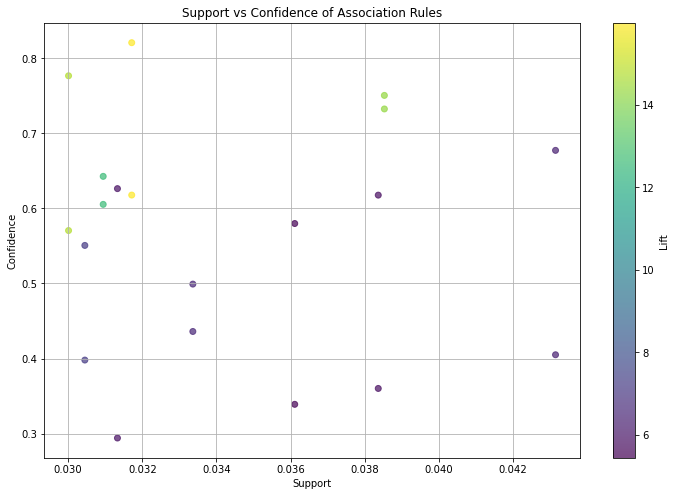

In [54]:
# Scatter Plot of Support vs. Confidence

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    Asso_Rules_UK['support'], 
    Asso_Rules_UK['confidence'],
    c=Asso_Rules_UK['lift'], 
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Lift')
plt.title('Support vs Confidence of Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

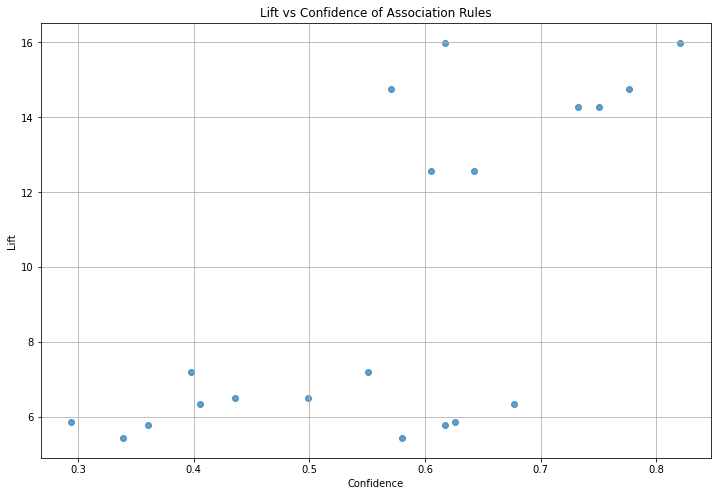

In [55]:
# Lift vs. Confidence Plot
plt.figure(figsize=(12, 8))
plt.scatter(
    Asso_Rules_UK['confidence'], 
    Asso_Rules_UK['lift'],
    alpha=0.7
)
plt.title('Lift vs Confidence of Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()

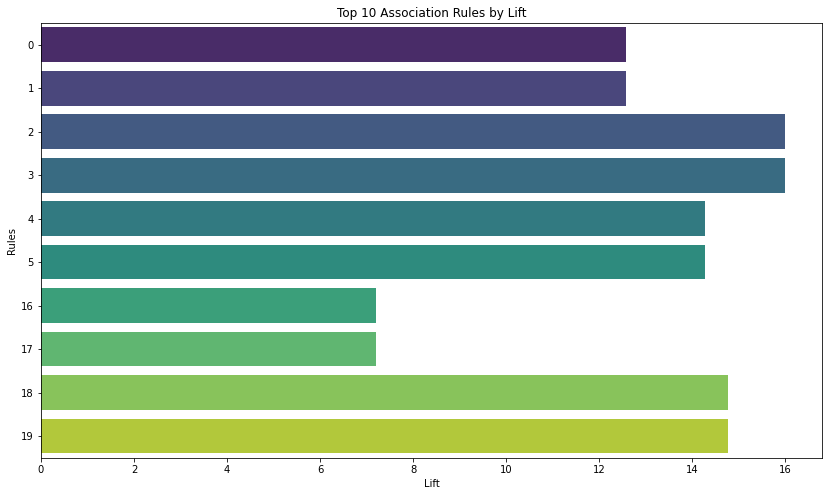

In [56]:
top_rules = Asso_Rules_UK.nlargest(10, 'lift')
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_rules, 
    x='lift', 
    y=top_rules.index,
    orient='h',
    palette='viridis'
)
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Rules')
plt.show()

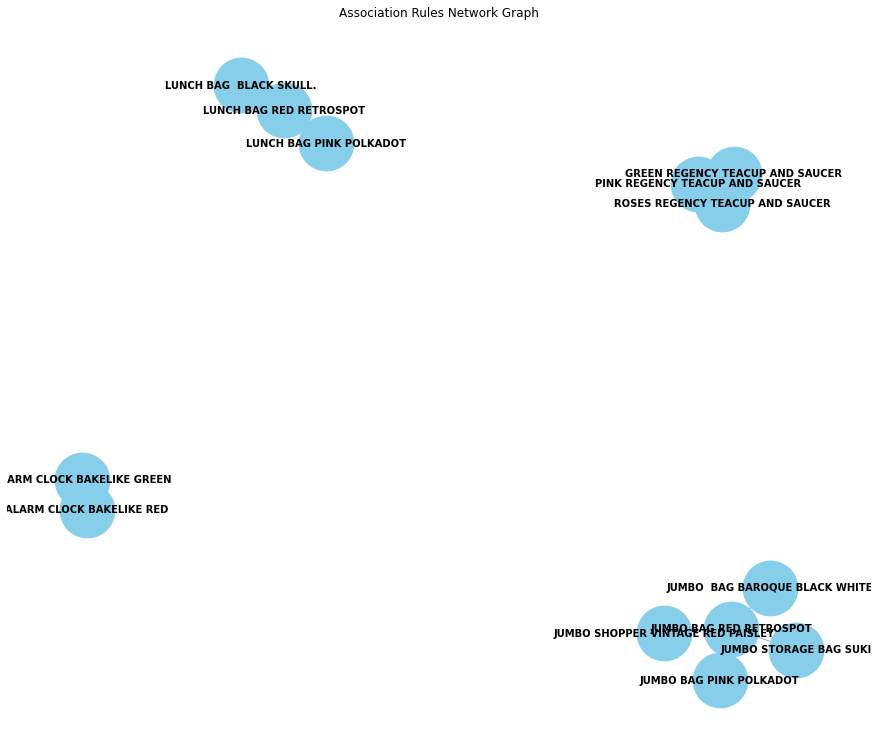

In [58]:
import networkx as nx

# Create a graph from the association rules
G = nx.Graph()

for _, row in Asso_Rules_UK.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Draw the network graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=[G[u][v]['weight'] / 10 for u, v in G.edges()])
plt.title('Association Rules Network Graph')
plt.show()

In [59]:
# Extract edges with weights
edges_data = pd.DataFrame(G.edges(data=True), columns=['Source', 'Target', 'Attributes'])

# Extract weight information
edges_data['Weight'] = edges_data['Attributes'].apply(lambda x: x.get('weight', 1))

print(edges_data[['Source', 'Target', 'Weight']].head())

                            Source                           Target     Weight
0       ALARM CLOCK BAKELIKE GREEN         ALARM CLOCK BAKELIKE RED  12.573307
1  GREEN REGENCY TEACUP AND SAUCER   PINK REGENCY TEACUP AND SAUCER  15.988282
2  GREEN REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER  14.268798
3   PINK REGENCY TEACUP AND SAUCER  ROSES REGENCY TEACUP AND SAUCER  14.765684
4          JUMBO BAG RED RETROSPOT   JUMBO  BAG BAROQUE BLACK WHITE   5.880414


In [60]:
edges_data

,Source,Target,Attributes,Weight
0,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,{'weight': 12.573307310845976},12.573307
1,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,{'weight': 15.988282094784967},15.988282
2,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,{'weight': 14.268798149105319},14.268798
3,PINK REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,{'weight': 14.765684014322852},14.765684
4,JUMBO BAG RED RETROSPOT,JUMBO BAG BAROQUE BLACK WHITE,{'weight': 5.880413703943115},5.880414
5,JUMBO BAG RED RETROSPOT,JUMBO BAG PINK POLKADOT,{'weight': 6.358587302138511},6.358587
6,JUMBO BAG RED RETROSPOT,JUMBO SHOPPER VINTAGE RED PAISLEY,{'weight': 5.443896720670893},5.443897
7,JUMBO BAG RED RETROSPOT,JUMBO STORAGE BAG SUKI,{'weight': 5.798977140926235},5.798977
8,LUNCH BAG BLACK SKULL.,LUNCH BAG RED RETROSPOT,{'weight': 6.524452463324258},6.524452
9,LUNCH BAG RED RETROSPOT,LUNCH BAG PINK POLKADOT,{'weight': 7.1978159776970365},7.197816


**Summary**

In this Market Basket Analysis, we have visualized the associations between products through a network graph, revealing significant relationships based on lift values from the association rules. The key insights from the network graph are:

1. **Strong Associations**:
   - **Product Pairings**: High-lift values indicate strong associations between certain products. For example, the pair “**PINK REGENCY TEACUP AND SAUCER**” and “**GREEN REGENCY TEACUP AND SAUCER**” exhibits a very high lift of 15.99, suggesting that these products are frequently purchased together. Similarly, “**PINK REGENCY TEACUP AND SAUCER**” and “**ROSES REGENCY TEACUP AND SAUCER**” have a high lift of 14.77, emphasizing their strong co-occurrence.
   - **Complementary Products**: Products such as “**ALARM CLOCK BAKELIKE GREEN**” and “**ALARM CLOCK BAKELIKE RED**” also demonstrate a notable lift of 12.57, indicating that customers who buy one are likely to buy the other as well.

2. **Potential for Cross-Selling**:
   - **Targeted Promotions**: The strong associations between specific products suggest opportunities for cross-selling and promotional strategies. For instance, promoting “**PINK REGENCY TEACUP AND SAUCER**” alongside “**GREEN REGENCY TEACUP AND SAUCER**” could enhance sales and customer satisfaction.
   - **Bundling Strategies**: The data supports bundling these frequently purchased products together in offers to boost sales and attract more customers.

3. **Inventory Management**:
   - **Stock Optimization**: Understanding these product relationships can help optimize inventory levels, ensuring that high-demand pairs are adequately stocked to meet customer expectations and prevent stockouts.